In [1]:
pip install selenium webdriver-manager pandas


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os, time, random, re
import pandas as pd
from urllib.parse import urljoin

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

BASE = "https://www.sikayetvar.com"
START = "https://www.sikayetvar.com/turkcell"

TARGET = 10000
OUTFILE = "turkcell_10k_segment.csv"
SAVE_EVERY = 1000

# Segment toplamak için kaç ana sayfa gezsin (arttırırsan segment artar)
SEGMENT_DISCOVERY_PAGES = 50

# Segment içinde kaç sayfa üst üste "0 yeni kayıt" olursa segmenti bırak
ZERO_STREAK_LIMIT = 5

options = Options()
options.add_argument("--headless=new")
options.add_argument("--window-size=1920,1080")
options.add_argument("--lang=tr-TR")
options.add_argument("--disable-gpu")
options.add_argument("--no-sandbox")
options.add_argument("--disable-dev-shm-usage")
options.add_argument("--disable-blink-features=AutomationControlled")
options.add_argument("--disable-extensions")
options.add_argument("--disable-notifications")

prefs = {
    "profile.managed_default_content_settings.images": 2,
    "profile.managed_default_content_settings.stylesheets": 2,
    "profile.managed_default_content_settings.fonts": 2,
}
options.add_experimental_option("prefs", prefs)

driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)
wait = WebDriverWait(driver, 10)

records, seen = [], set()

# CSV varsa devam
if os.path.exists(OUTFILE):
    try:
        old = pd.read_csv(OUTFILE)
        for _, r in old.iterrows():
            link = str(r.get("link","")).strip()
            if link:
                seen.add(link)
            records.append({
                "segment": str(r.get("segment","")).strip(),
                "tarih": str(r.get("tarih","")).strip(),
                "kullanici": str(r.get("kullanici","")).strip(),
                "baslik": str(r.get("baslik","")).strip(),
                "ozet": str(r.get("ozet","")).strip(),
                "link": link
            })
        print("📌 Devam:", len(records))
    except:
        print("⚠️ CSV okunamadı, sıfırdan.")

def save():
    pd.DataFrame(records).to_csv(OUTFILE, index=False, encoding="utf-8-sig")
    print("💾 Kaydedildi | Toplam:", len(records))

def nap(a=0.2, b=0.6):
    time.sleep(random.uniform(a, b))

def get_max_pages():
    # title içinde 2/200 gibi ifade varsa 200'ü okur
    links = driver.find_elements(By.CSS_SELECTOR, "a.page-link[title]")
    for a in links:
        t = a.get_attribute("title") or ""
        m = re.search(r"(\d+)\s*/\s*(\d+)", t)
        if m:
            return int(m.group(2))
    return 200

def discover_segments():
    segs = set()
    for p in range(1, SEGMENT_DISCOVERY_PAGES + 1):
        url = f"{START}?page={p}"
        driver.get(url)
        try:
            wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, "article")))
        except:
            continue

        # ✅ Senin HTML’deki etiket butonları: a.sv-model-button
        tag_links = driver.find_elements(By.CSS_SELECTOR, "a.sv-model-button[href^='/turkcell/']")
        for a in tag_links:
            href = (a.get_attribute("href") or "").strip()
            if href and "page=" not in href:
                segs.add(href)

        if p % 10 == 0:
            print(f"🔎 Segment keşfi: {p}/{SEGMENT_DISCOVERY_PAGES} | Bulunan segment: {len(segs)}")
        nap(0.15, 0.4)

    # ana sayfayı da dahil et
    segs.add(START)

    # öncelikli birkaç segment (varsa)
    priority = [
        START,
        "https://www.sikayetvar.com/turkcell/internet",
        "https://www.sikayetvar.com/turkcell/fatura",
        "https://www.sikayetvar.com/turkcell/taahhut",
        "https://www.sikayetvar.com/turkcell/musteri-hizmetleri",
        "https://www.sikayetvar.com/turkcell/paket",
    ]
    ordered = []
    for x in priority:
        if x in segs:
            ordered.append(x)
            segs.discard(x)
    ordered.extend(sorted(segs))
    return ordered

try:
    segments = discover_segments()
    print("✅ Toplam segment:", len(segments))

    for seg in segments:
        if len(records) >= TARGET:
            break

        driver.get(seg)
        try:
            wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, "article")))
        except:
            continue

        maxp = get_max_pages()
        seg_name = seg.replace(BASE, "")
        print(f"\n🔷 Segment: {seg_name} | max page: {maxp}")

        zero_streak = 0

        for page in range(1, maxp + 1):
            if len(records) >= TARGET:
                break

            url = f"{seg}?page={page}" if "?" not in seg else f"{seg}&page={page}"
            driver.get(url)
            try:
                wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, "article")))
            except:
                break

            articles = driver.find_elements(By.CSS_SELECTOR, "article")
            new_on_page = 0

            for art in articles:
                if len(records) >= TARGET:
                    break
                try:
                    a = art.find_element(By.CSS_SELECTOR, "a.complaint-layer")
                    href = (a.get_attribute("href") or "").strip()
                    if not href:
                        continue
                    link = urljoin(BASE, href)
                    if link in seen:
                        continue

                    title = a.get_attribute("title") or a.text.strip()

                    user = ""
                    u = art.find_elements(By.CSS_SELECTOR, "span.username")
                    if u: user = u[0].text.strip()

                    dt = ""
                    t = art.find_elements(By.CSS_SELECTOR, "div.js-tooltip.time")
                    if t: dt = t[0].text.strip()

                    summary = ""
                    p_el = art.find_elements(By.CSS_SELECTOR, "p.complaint-description")
                    if p_el: summary = p_el[0].text.strip()

                    seen.add(link)
                    records.append({
                        "segment": seg_name,
                        "tarih": dt,
                        "kullanici": user,
                        "baslik": title,
                        "ozet": summary,
                        "link": link
                    })
                    new_on_page += 1
                except:
                    pass

            if new_on_page == 0:
                zero_streak += 1
            else:
                zero_streak = 0

            if page % 10 == 0:
                print(f"  📄 {page}/{maxp} +{new_on_page} | Toplam:{len(records)} | zero_streak:{zero_streak}")

            if len(records) % SAVE_EVERY == 0:
                save()

            if zero_streak >= ZERO_STREAK_LIMIT:
                # segment çok overlap yapıyor; vakit kaybetmeyelim
                break

            nap()

finally:
    save()
    driver.quit()
    print("🏁 Bitti | Toplam:", len(records))


📌 Devam: 8851
🔎 Segment keşfi: 10/50 | Bulunan segment: 27
🔎 Segment keşfi: 20/50 | Bulunan segment: 32
🔎 Segment keşfi: 30/50 | Bulunan segment: 32
🔎 Segment keşfi: 40/50 | Bulunan segment: 36
🔎 Segment keşfi: 50/50 | Bulunan segment: 37
✅ Toplam segment: 38

🔷 Segment: /turkcell | max page: 200

🔷 Segment: /turkcell/internet | max page: 200

🔷 Segment: /turkcell/fatura | max page: 200

🔷 Segment: /turkcell/taahhut | max page: 200

🔷 Segment: /turkcell/arac-takip | max page: 200

🔷 Segment: /turkcell/askercell | max page: 200

🔷 Segment: /turkcell/avans-tl | max page: 200

🔷 Segment: /turkcell/cayma-bedeli | max page: 200

🔷 Segment: /turkcell/cocuk-hatti | max page: 200

🔷 Segment: /turkcell/dijital-servisler | max page: 200

🔷 Segment: /turkcell/esim | max page: 200

🔷 Segment: /turkcell/faturali-paketler | max page: 200

🔷 Segment: /turkcell/faturasiz-paketler | max page: 200

🔷 Segment: /turkcell/gnctrkcll | max page: 200

🔷 Segment: /turkcell/hat-aktivasyonu | max page: 200

🔷 Se

In [3]:
pip install requests beautifulsoup4 lxml pandas


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
import os, time, random
import pandas as pd
from datetime import datetime

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC


TOPIC_NAME = "turkcell"
TOPIC_URL  = "https://eksisozluk.com/turkcell--36082"

# Ana dosyaya dokunma, hep append yaz (güvenli)
MAIN_CSV   = "eksi_turkcell_main.csv"
APPEND_CSV = "eksi_turkcell_append.csv"
MERGED_CSV = "eksi_turkcell_merged.csv"

def backup_if_exists(path):
    if os.path.exists(path) and os.path.getsize(path) > 0:
        ts = datetime.now().strftime("%Y%m%d_%H%M%S")
        bak = path.replace(".csv", f".bak_{ts}.csv")
        with open(path, "rb") as src, open(bak, "wb") as dst:
            dst.write(src.read())
        print("🧷 Yedek:", bak)

backup_if_exists(APPEND_CSV)
backup_if_exists(MAIN_CSV)

options = Options()
options.add_argument("--headless=new")
options.add_argument("--window-size=1920,1080")
options.add_argument("--lang=tr-TR")
options.add_argument("--disable-gpu")
options.add_argument("--no-sandbox")
options.add_argument("--disable-dev-shm-usage")
options.add_argument("--disable-blink-features=AutomationControlled")
options.add_argument("--disable-extensions")
options.add_argument("--disable-notifications")
options.add_argument("--disable-popup-blocking")
options.add_argument("--user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/122.0.0.0 Safari/537.36")

# hız
prefs = {
    "profile.managed_default_content_settings.images": 2,
    "profile.managed_default_content_settings.stylesheets": 2,
    "profile.managed_default_content_settings.fonts": 2,
}
options.add_experimental_option("prefs", prefs)

driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)
wait = WebDriverWait(driver, 12)

def nap():
    time.sleep(random.uniform(0.25, 0.65))

# resume sayfasını bul (main + append içinden en büyük sayfa)
start_page = 1
append_rows = []

def max_page_from_csv(path):
    if os.path.exists(path) and os.path.getsize(path) > 0:
        df = pd.read_csv(path)
        if not df.empty and "sayfa" in df.columns:
            df["sayfa"] = pd.to_numeric(df["sayfa"], errors="coerce")
            m = df["sayfa"].dropna().max()
            if pd.notna(m):
                return int(m)
    return None

m1 = max_page_from_csv(MAIN_CSV)
m2 = max_page_from_csv(APPEND_CSV)
last = max([x for x in [m1, m2] if x is not None], default=0)
start_page = last + 1
print(f"▶️ DEVAM: sayfa {start_page}")

# append varsa yükle
if os.path.exists(APPEND_CSV) and os.path.getsize(APPEND_CSV) > 0:
    try:
        append_rows = pd.read_csv(APPEND_CSV).to_dict("records")
        print("📌 Append yüklendi:", len(append_rows))
    except:
        append_rows = []

def save_append():
    if len(append_rows) == 0:
        print("🛑 Append boş, yazmıyorum.")
        return
    pd.DataFrame(append_rows).to_csv(APPEND_CSV, index=False, encoding="utf-8-sig")
    print("💾 Append kaydedildi:", len(append_rows))

page = start_page

try:
    while True:
        url = f"{TOPIC_URL}?p={page}"
        driver.get(url)

        # 403/engel olursa sayfada entry listesi gelmez
        try:
            wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, "ul#entry-item-list li")))
        except:
            print(f"❌ Sayfa {page}: entry listesi yok. (engel/boş) Duruyor.")
            break

        entries = driver.find_elements(By.CSS_SELECTOR, "ul#entry-item-list li")
        if not entries:
            print(f"⛔ Sayfa {page}: entry yok. Bitti.")
            break

        for e in entries:
            try:
                text = e.find_element(By.CSS_SELECTOR, "div.content").text.strip()
                author = e.find_element(By.CSS_SELECTOR, "a.entry-author").text.strip()
                date = e.find_element(By.CSS_SELECTOR, "a.entry-date").text.strip()
                append_rows.append({
                    "kaynak": "eksi",
                    "baslik": TOPIC_NAME,
                    "yazar": author,
                    "tarih": date,
                    "entry": text,
                    "sayfa": page,
                    "url": url
                })
            except:
                continue

        if page % 10 == 0:
            print(f"📄 Sayfa {page} | Append: {len(append_rows)}")
            save_append()

        # pagination
        next_btn = driver.find_elements(By.CSS_SELECTOR, "a.next[rel='next']")
        if not next_btn:
            print("🏁 Son sayfa.")
            break

        page += 1
        nap()

finally:
    save_append()
    driver.quit()

# main + append birleştir (main yoksa sadece append)
dfs = []
if os.path.exists(MAIN_CSV) and os.path.getsize(MAIN_CSV) > 0:
    dfs.append(pd.read_csv(MAIN_CSV))
if os.path.exists(APPEND_CSV) and os.path.getsize(APPEND_CSV) > 0:
    dfs.append(pd.read_csv(APPEND_CSV))

if dfs:
    merged = pd.concat(dfs, ignore_index=True)
    merged.to_csv(MERGED_CSV, index=False, encoding="utf-8-sig")
    print("✅ Birleşik:", MERGED_CSV, "| Toplam:", len(merged))
else:
    print("⚠️ Veri oluşmadı.")


🧷 Yedek: eksi_turkcell_append.bak_20260118_135627.csv
▶️ DEVAM: sayfa 842
📌 Append yüklendi: 8401
❌ Sayfa 842: entry listesi yok. (engel/boş) Duruyor.
💾 Append kaydedildi: 8401
✅ Birleşik: eksi_turkcell_merged.csv | Toplam: 8401


In [6]:
import pandas as pd

SIKAYETVAR_CSV = "turkcell_10k_segment.csv"
EKSI_CSV       = "eksi_turkcell_merged.csv"
OUTFILE        = "gsm.csv"

sv = pd.read_csv(SIKAYETVAR_CSV)
sv_out = pd.DataFrame({
    "kaynak": "sikayetvar",
    "konu": sv.get("segment", "/turkcell").astype(str),
    "tarih": sv.get("tarih", "").astype(str),
    "yazar": sv.get("kullanici", "").astype(str),
    "baslik": sv.get("baslik", "").astype(str),
    "metin": sv.get("ozet", sv.get("metin", "")).astype(str),
    "url": sv.get("link", "").astype(str),
})

eksi = pd.read_csv(EKSI_CSV)

# Ekşi metin kolonu entry/metin olabilir
text_col = "entry" if "entry" in eksi.columns else "metin"
eksi_out = pd.DataFrame({
    "kaynak": "eksi",
    "konu": eksi.get("baslik", "turkcell").astype(str),
    "tarih": eksi.get("tarih", "").astype(str),
    "yazar": eksi.get("yazar", "").astype(str),
    "baslik": eksi.get("baslik", "").astype(str),
    "metin": eksi[text_col].astype(str),
    "url": eksi.get("url", "").astype(str),
})

all_df = pd.concat([sv_out, eksi_out], ignore_index=True)
all_df["metin"] = all_df["metin"].fillna("").astype(str)
all_df = all_df[all_df["metin"].str.strip() != ""]

# Şimdilik dedup YAPMIYORUZ (önce tam sayıyı görelim)
all_df.to_csv(OUTFILE, index=False, encoding="utf-8-sig")

print("✅ Bitti")
print("Şikayetvar:", len(sv_out))
print("Ekşi:", len(eksi_out))
print("Toplam:", len(all_df))
print("Çıktı:", OUTFILE)


✅ Bitti
Şikayetvar: 8875
Ekşi: 8401
Toplam: 17276
Çıktı: gsm.csv


In [7]:
import os, time, random, csv
import pandas as pd

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException

# =========================
# AYARLAR
# =========================
CITY = "İstanbul"
QUERY = f"Turkcell İletişim Merkezi {CITY}"

TARGET_PLACES = 160
REVIEWS_PER_PLACE_CAP = 60
SCROLL_PASSES = 8
TOTAL_TARGET = 20000

OUTFILE = "gmaps_turkcell_istanbul_fast.csv"
VISITED_PLACES_FILE = "visited_places_istanbul.txt"

HEADLESS = False  # Google Maps için genelde False daha stabil
SAVE_EVERY = 800

# =========================
# CHROME
# =========================
options = Options()
if HEADLESS:
    options.add_argument("--headless=new")

options.add_argument("--window-size=1400,900")
options.add_argument("--lang=tr-TR")
options.add_argument("--disable-gpu")
options.add_argument("--no-sandbox")
options.add_argument("--disable-dev-shm-usage")
options.add_argument("--disable-blink-features=AutomationControlled")
options.add_argument("--disable-extensions")
options.add_argument("--disable-notifications")
options.add_argument("--disable-popup-blocking")
options.add_argument("--user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/122.0.0.0 Safari/537.36")

options.add_argument(r"--user-data-dir=C:\gmaps_profile")
options.add_argument("--profile-directory=Default")

prefs = {
    "profile.managed_default_content_settings.images": 2,
    "profile.managed_default_content_settings.stylesheets": 2,
    "profile.managed_default_content_settings.fonts": 2,
}
options.add_experimental_option("prefs", prefs)

driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)
wait = WebDriverWait(driver, 20)

def nap(a=0.08, b=0.22):
    time.sleep(random.uniform(a, b))

# =========================
# DEVAM ETME
# =========================
records = []
seen = set()

if os.path.exists(OUTFILE) and os.path.getsize(OUTFILE) > 0:
    old = pd.read_csv(OUTFILE)
    for _, r in old.iterrows():
        place = str(r.get("place_url","")).strip()
        author = str(r.get("author","")).strip()
        when = str(r.get("time","")).strip()
        text = str(r.get("text","")).strip()
        seen.add((place, author, when, text[:40]))
        records.append(r.to_dict())
    print("▶️ Devam | mevcut yorum:", len(records))

visited_places = set()
if os.path.exists(VISITED_PLACES_FILE):
    with open(VISITED_PLACES_FILE, "r", encoding="utf-8") as f:
        visited_places = set(x.strip() for x in f if x.strip())
    print("▶️ Ziyaret edilmiş şube:", len(visited_places))

def mark_visited(url):
    if url in visited_places:
        return
    visited_places.add(url)
    with open(VISITED_PLACES_FILE, "a", encoding="utf-8") as f:
        f.write(url + "\n")

def save():
    if not records:
        return
    pd.DataFrame(records).to_csv(OUTFILE, index=False, encoding="utf-8-sig", quoting=csv.QUOTE_ALL)
    print("💾 Kaydedildi | Toplam:", len(records))

# =========================
# LINK TOPLA
# =========================
def collect_place_urls(target_n: int):
    search_url = f"https://www.google.com/maps/search/{QUERY.replace(' ', '+')}/"
    driver.get(search_url)

    wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, "div[role='feed']")))
    feed = driver.find_element(By.CSS_SELECTOR, "div[role='feed']")

    urls = []
    stable = 0
    last = 0

    while len(urls) < target_n and stable < 10:
        cards = driver.find_elements(By.CSS_SELECTOR, "a.hfpxzc")
        for a in cards:
            href = a.get_attribute("href")
            if href and "/maps/place/" in href and href not in urls:
                urls.append(href)

        driver.execute_script("arguments[0].scrollTop = arguments[0].scrollTop + arguments[0].offsetHeight;", feed)
        nap(0.08, 0.16)

        if len(urls) == last:
            stable += 1
        else:
            stable = 0
            last = len(urls)

    return urls[:target_n]

# =========================
# YORUMLAR SELECTOR
# =========================
REVIEW_TEXT_SEL = "span.wiI7pd, div.MyEned span.wiI7pd"
REVIEW_CARD_SEL = "div[data-review-id], div.jftiEf"

TAB_SEL_TR = "button[role='tab'][aria-label*='yorumlar']"
TAB_SEL_EN = "button[role='tab'][aria-label*='reviews']"
TAB_SEL = f"{TAB_SEL_TR}, {TAB_SEL_EN}"

def find_reviews_scrollbox():
    candidates = driver.find_elements(By.CSS_SELECTOR, "div.m6QErb.DxyBCb.kA9KIf.dS8AEf, div[role='feed']")
    best = None
    best_cnt = 0
    for c in candidates:
        try:
            cnt = len(c.find_elements(By.CSS_SELECTOR, REVIEW_TEXT_SEL))
            if cnt > best_cnt:
                best_cnt = cnt
                best = c
        except:
            pass
    return best

def scrape_place(place_url: str):
    driver.get(place_url)

    # ✅ SAYFA GERÇEKTEN YÜKLENSİN: hem h1 hem de tab bekle
    try:
        wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, "h1")))
        wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, TAB_SEL)))
    except TimeoutException:
        mark_visited(place_url)
        return 0

    # şube adı
    try:
        place_name = driver.find_element(By.CSS_SELECTOR, "h1").text.strip()
    except:
        place_name = ""

    # ✅ Yorumlar sekmesine tıkla
    tabs = driver.find_elements(By.CSS_SELECTOR, TAB_SEL)
    if not tabs:
        mark_visited(place_url)
        return 0
    try:
        driver.execute_script("arguments[0].click();", tabs[0])
    except:
        mark_visited(place_url)
        return 0

    # ✅ yorum metni gelene kadar bekle (en kritik)
    ok = False
    for _ in range(4):
        try:
            wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, REVIEW_TEXT_SEL)))
            ok = True
            break
        except TimeoutException:
            time.sleep(0.8)
    if not ok:
        mark_visited(place_url)
        return 0

    # ✅ scrollbox bul (denemeli)
    scrollbox = None
    for _ in range(4):
        scrollbox = find_reviews_scrollbox()
        if scrollbox is not None:
            break
        time.sleep(0.6)
    if scrollbox is None:
        mark_visited(place_url)
        return 0

    added = 0

    for _ in range(SCROLL_PASSES):
        cards = scrollbox.find_elements(By.CSS_SELECTOR, REVIEW_CARD_SEL)
        for card in cards:
            if added >= REVIEWS_PER_PLACE_CAP:
                break

            author = ""
            try:
                author = card.find_element(By.CSS_SELECTOR, "div.d4r55").text.strip()
            except:
                pass

            rating = ""
            try:
                rating = card.find_element(By.CSS_SELECTOR, "span.kvMYJc").get_attribute("aria-label") or ""
            except:
                pass

            when = ""
            try:
                when = card.find_element(By.CSS_SELECTOR, "span.rsqaWe").text.strip()
            except:
                pass

            text = ""
            try:
                t = card.find_elements(By.CSS_SELECTOR, "span.wiI7pd")
                if t:
                    text = t[-1].text.strip()
            except:
                pass

            key = (place_url, author, when, text[:40])
            if key in seen:
                continue

            seen.add(key)
            records.append({
                "kaynak": "google_maps",
                "query": QUERY,
                "city": CITY,
                "place_name": place_name,
                "place_url": place_url,
                "author": author,
                "rating": rating,
                "time": when,
                "text": text
            })
            added += 1

        if len(records) % SAVE_EVERY == 0:
            save()

        if added >= REVIEWS_PER_PLACE_CAP:
            break

        driver.execute_script("arguments[0].scrollTop = arguments[0].scrollTop + arguments[0].offsetHeight;", scrollbox)
        nap(0.08, 0.22)

    mark_visited(place_url)
    return added

# =========================
# MAIN
# =========================
try:
    places = collect_place_urls(TARGET_PLACES)
    print("✅ Şube:", len(places))

    for i, p in enumerate(places, start=1):
        if len(records) >= TOTAL_TARGET:
            print("🎯 Hedefe ulaşıldı:", TOTAL_TARGET)
            break
        if p in visited_places:
            continue

        got = scrape_place(p)
        print(f"🏬 {i}/{len(places)} | +{got} | Toplam:{len(records)}")
        nap(0.15, 0.35)

finally:
    save()
    driver.quit()
    print("🏁 Bitti | Toplam:", len(records), "| Dosya:", OUTFILE)


▶️ Devam | mevcut yorum: 750
▶️ Ziyaret edilmiş şube: 114
✅ Şube: 20
🏬 13/20 | +0 | Toplam:750
💾 Kaydedildi | Toplam: 750
🏁 Bitti | Toplam: 750 | Dosya: gmaps_turkcell_istanbul_fast.csv


In [8]:
import os, time, random, csv
import pandas as pd

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException

# =========================
# AYARLAR
# =========================
CITIES = ["İstanbul", "Ankara", "İzmir", "Bursa", "Antalya"]
BASE_QUERY = "Turkcell İletişim Merkezi"

TARGET_PLACES_PER_CITY = 140      # şehir başına kaç şube linki
REVIEWS_PER_PLACE_CAP = 60        # şube başına max yorum (hız)
SCROLL_PASSES = 8                 # şube başına scroll turu (hız)
TOTAL_TARGET = 50000              # toplam hedef (5 şehirde 20-40K normal; yetmezse artırırız)

OUTFILE = "gmaps_turkcell_5cities.csv"
VISITED_FILE = "visited_places_5cities.txt"

HEADLESS = False                  # önce False (stabil). True istersen dene.
SAVE_EVERY = 800

# =========================
# CHROME
# =========================
options = Options()
if HEADLESS:
    options.add_argument("--headless=new")

options.add_argument("--window-size=1400,900")
options.add_argument("--lang=tr-TR")
options.add_argument("--disable-gpu")
options.add_argument("--no-sandbox")
options.add_argument("--disable-dev-shm-usage")
options.add_argument("--disable-blink-features=AutomationControlled")
options.add_argument("--disable-extensions")
options.add_argument("--disable-notifications")
options.add_argument("--disable-popup-blocking")
options.add_argument("--user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/122.0.0.0 Safari/537.36")

# ✅ Profil: bot riskini azaltır
options.add_argument(r"--user-data-dir=C:\gmaps_profile")
options.add_argument("--profile-directory=Default")

# hız: görsel+css+font kapat
prefs = {
    "profile.managed_default_content_settings.images": 2,
    "profile.managed_default_content_settings.stylesheets": 2,
    "profile.managed_default_content_settings.fonts": 2,
}
options.add_experimental_option("prefs", prefs)

driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)
wait = WebDriverWait(driver, 18)

def nap(a=0.06, b=0.18):
    time.sleep(random.uniform(a, b))

# =========================
# RESUME: CSV + visited
# =========================
records = []
seen = set()  # (place_url, author, time, text[:40])

if os.path.exists(OUTFILE) and os.path.getsize(OUTFILE) > 0:
    try:
        old = pd.read_csv(OUTFILE)
        for _, r in old.iterrows():
            place = str(r.get("place_url","")).strip()
            author = str(r.get("author","")).strip()
            when = str(r.get("time","")).strip()
            text = str(r.get("text","")).strip()
            seen.add((place, author, when, text[:40]))
            records.append(r.to_dict())
        print("▶️ Devam | mevcut yorum:", len(records))
    except:
        print("⚠️ CSV okunamadı, sıfırdan başlayacak.")

visited_places = set()
if os.path.exists(VISITED_FILE):
    with open(VISITED_FILE, "r", encoding="utf-8") as f:
        visited_places = set(x.strip() for x in f if x.strip())
    print("▶️ Ziyaret edilmiş şube:", len(visited_places))

def mark_visited(place_url: str):
    if place_url in visited_places:
        return
    visited_places.add(place_url)
    with open(VISITED_FILE, "a", encoding="utf-8") as f:
        f.write(place_url + "\n")

def save():
    if not records:
        return
    pd.DataFrame(records).to_csv(OUTFILE, index=False, encoding="utf-8-sig", quoting=csv.QUOTE_ALL)
    print("💾 Kaydedildi | Toplam:", len(records))

# =========================
# Maps yardımcıları
# =========================
REVIEW_TEXT_SEL = "span.wiI7pd, div.MyEned span.wiI7pd"
REVIEW_CARD_SEL = "div[data-review-id], div.jftiEf"
TAB_SEL = "button[role='tab'][aria-label*='yorumlar'], button[role='tab'][aria-label*='reviews']"

def collect_place_urls(query: str, target_n: int):
    search_url = f"https://www.google.com/maps/search/{query.replace(' ', '+')}/"
    driver.get(search_url)

    try:
        wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, "div[role='feed']")))
    except TimeoutException:
        return []

    feed = driver.find_element(By.CSS_SELECTOR, "div[role='feed']")

    urls = []
    stable = 0
    last = 0

    while len(urls) < target_n and stable < 10:
        cards = driver.find_elements(By.CSS_SELECTOR, "a.hfpxzc")
        for a in cards:
            href = a.get_attribute("href")
            if href and "/maps/place/" in href and href not in urls:
                urls.append(href)

        driver.execute_script("arguments[0].scrollTop = arguments[0].scrollTop + arguments[0].offsetHeight;", feed)
        nap(0.07, 0.16)

        if len(urls) == last:
            stable += 1
        else:
            stable = 0
            last = len(urls)

    return urls[:target_n]

def find_reviews_scrollbox():
    candidates = driver.find_elements(By.CSS_SELECTOR, "div.m6QErb.DxyBCb.kA9KIf.dS8AEf, div[role='feed']")
    best = None
    best_cnt = 0
    for c in candidates:
        try:
            cnt = len(c.find_elements(By.CSS_SELECTOR, REVIEW_TEXT_SEL))
            if cnt > best_cnt:
                best_cnt = cnt
                best = c
        except:
            pass
    return best

def scrape_place(place_url: str, city: str, query: str):
    driver.get(place_url)

    # ✅ gerçekten yüklenmesini bekle: h1 + tab
    try:
        wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, "h1")))
        wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, TAB_SEL)))
    except TimeoutException:
        mark_visited(place_url)
        return 0

    try:
        place_name = driver.find_element(By.CSS_SELECTOR, "h1").text.strip()
    except:
        place_name = ""

    # yorumlar tabına tıkla
    tabs = driver.find_elements(By.CSS_SELECTOR, TAB_SEL)
    if not tabs:
        mark_visited(place_url)
        return 0
    try:
        driver.execute_script("arguments[0].click();", tabs[0])
    except:
        mark_visited(place_url)
        return 0

    # yorum metnini bekle (kritik)
    ok = False
    for _ in range(4):
        try:
            wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, REVIEW_TEXT_SEL)))
            ok = True
            break
        except TimeoutException:
            time.sleep(0.7)
    if not ok:
        mark_visited(place_url)
        return 0

    # scrollbox
    scrollbox = None
    for _ in range(3):
        scrollbox = find_reviews_scrollbox()
        if scrollbox is not None:
            break
        time.sleep(0.6)
    if scrollbox is None:
        mark_visited(place_url)
        return 0

    added = 0

    for _ in range(SCROLL_PASSES):
        cards = scrollbox.find_elements(By.CSS_SELECTOR, REVIEW_CARD_SEL)

        for card in cards:
            if added >= REVIEWS_PER_PLACE_CAP:
                break

            author = ""
            try:
                author = card.find_element(By.CSS_SELECTOR, "div.d4r55").text.strip()
            except:
                pass

            rating = ""
            try:
                rating = card.find_element(By.CSS_SELECTOR, "span.kvMYJc").get_attribute("aria-label") or ""
            except:
                pass

            when = ""
            try:
                when = card.find_element(By.CSS_SELECTOR, "span.rsqaWe").text.strip()
            except:
                pass

            text = ""
            try:
                t = card.find_elements(By.CSS_SELECTOR, "span.wiI7pd")
                if t:
                    text = t[-1].text.strip()
            except:
                pass

            key = (place_url, author, when, text[:40])
            if key in seen:
                continue

            seen.add(key)
            records.append({
                "kaynak": "google_maps",
                "query": query,
                "city": city,
                "place_name": place_name,
                "place_url": place_url,
                "author": author,
                "rating": rating,
                "time": when,
                "text": text
            })
            added += 1

        if len(records) % SAVE_EVERY == 0:
            save()

        if added >= REVIEWS_PER_PLACE_CAP:
            break

        driver.execute_script("arguments[0].scrollTop = arguments[0].scrollTop + arguments[0].offsetHeight;", scrollbox)
        nap()

    mark_visited(place_url)
    return added

# =========================
# MAIN
# =========================
try:
    for city in CITIES:
        if len(records) >= TOTAL_TARGET:
            break

        query = f"{BASE_QUERY} {city}"
        print(f"\n🌆 Şehir: {city} | Arama: {query}")

        place_urls = collect_place_urls(query, TARGET_PLACES_PER_CITY)
        print("✅ Şube linki:", len(place_urls))

        for i, purl in enumerate(place_urls, start=1):
            if len(records) >= TOTAL_TARGET:
                break
            if purl in visited_places:
                continue

            got = scrape_place(purl, city, query)
            print(f"  🏬 {i}/{len(place_urls)} | +{got} | Toplam:{len(records)}")
            nap(0.12, 0.35)

finally:
    save()
    driver.quit()
    print("🏁 Bitti | Toplam:", len(records), "| Dosya:", OUTFILE)



🌆 Şehir: İstanbul | Arama: Turkcell İletişim Merkezi İstanbul
✅ Şube linki: 111
  🏬 1/111 | +11 | Toplam:11
  🏬 2/111 | +20 | Toplam:31
  🏬 3/111 | +10 | Toplam:41
  🏬 4/111 | +20 | Toplam:61
  🏬 5/111 | +10 | Toplam:71
  🏬 6/111 | +10 | Toplam:81
  🏬 7/111 | +20 | Toplam:101
  🏬 8/111 | +20 | Toplam:121
  🏬 9/111 | +20 | Toplam:141
  🏬 10/111 | +10 | Toplam:151
  🏬 11/111 | +10 | Toplam:161
  🏬 12/111 | +20 | Toplam:181
  🏬 13/111 | +0 | Toplam:181
  🏬 14/111 | +10 | Toplam:191
  🏬 15/111 | +10 | Toplam:201
  🏬 16/111 | +0 | Toplam:201
  🏬 17/111 | +0 | Toplam:201
  🏬 18/111 | +20 | Toplam:221
  🏬 19/111 | +10 | Toplam:231
  🏬 20/111 | +20 | Toplam:251
  🏬 21/111 | +10 | Toplam:261
  🏬 22/111 | +20 | Toplam:281
  🏬 23/111 | +0 | Toplam:281
  🏬 24/111 | +20 | Toplam:301
  🏬 25/111 | +20 | Toplam:321
  🏬 26/111 | +0 | Toplam:321
  🏬 27/111 | +0 | Toplam:321
  🏬 28/111 | +11 | Toplam:332
  🏬 29/111 | +20 | Toplam:352
  🏬 30/111 | +10 | Toplam:362
  🏬 31/111 | +0 | Toplam:362
  🏬 32/111 

In [10]:
import os
import glob
import pandas as pd

OUTPUT = "ALL_COMBINED.csv"

# CSV’leri bul (aynı klasördeki hepsi)
csv_files = [f for f in glob.glob("*.csv") if os.path.basename(f) != OUTPUT]

if not csv_files:
    raise SystemExit("Bu klasörde birleştirilecek CSV bulunamadı.")

def normalize(df: pd.DataFrame, filename: str) -> pd.DataFrame:
    df = df.copy()
    df.columns = [c.strip() for c in df.columns]

    # Kaynak tahmini (dosya adına göre)
    lower = filename.lower()
    source = "unknown"
    if "sikayet" in lower or "sikayetvar" in lower:
        source = "sikayetvar"
    elif "eksi" in lower:
        source = "eksi"
    elif "gmaps" in lower or "maps" in lower or "google" in lower:
        source = "google_maps"

    # Metin alanlarını ortak "content" alanına indir
    content_candidates = ["content", "text", "entry", "metin", "ozet", "yorum", "comment"]
    content_col = None
    for c in content_candidates:
        if c in df.columns:
            content_col = c
            break

    if content_col is None:
        # hiç içerik kolonu yoksa boş bırak
        df["content"] = ""
    else:
        df["content"] = df[content_col].astype(str)

    # Bazı standart alanları toparla (varsa)
    def pick(*names):
        for n in names:
            if n in df.columns:
                return df[n].astype(str)
        return ""

    df["title"] = pick("baslik", "title", "place_name")
    df["author"] = pick("yazar", "author", "kullanici", "username")
    df["time"] = pick("tarih", "time", "date", "entry_date")
    df["url"] = pick("link", "url", "place_url")

    # kaynak + dosya adı
    df["source"] = df.get("kaynak", source)
    df["source_file"] = filename

    # Temel boşluk temizliği (silme yapmıyor, sadece trim)
    df["content"] = df["content"].fillna("").astype(str)
    df["content"] = df["content"].str.replace("\r", " ", regex=False).str.replace("\n", " ", regex=False)
    df["content"] = df["content"].str.strip()

    # En sonda sadece gerekli kolonlar kalsın (istersen artırırız)
    cols = ["source", "source_file", "title", "author", "time", "content", "url"]
    return df[cols]

all_parts = []
total_rows = 0

for f in csv_files:
    try:
        df = pd.read_csv(f, encoding="utf-8-sig", engine="python")
    except Exception:
        # bazı dosyalar farklı encoding olabilir
        df = pd.read_csv(f, encoding="utf-8", engine="python", errors="replace")

    norm = normalize(df, os.path.basename(f))
    all_parts.append(norm)
    total_rows += len(norm)
    print(f"✅ Okundu: {f} | satır: {len(norm)}")

merged = pd.concat(all_parts, ignore_index=True)

# Tamamen boş content satırlarını istersen atabiliriz ama SEN “silmesin” demiştin.
# O yüzden atmıyorum.

merged.to_csv(OUTPUT, index=False, encoding="utf-8-sig")
print(f"\n🏁 Birleştirildi: {OUTPUT}")
print("Toplam satır:", len(merged))
print("Dosya sayısı:", len(csv_files))


✅ Okundu: eksi_turkcell_append.bak_20260118_135313.csv | satır: 8401
✅ Okundu: eksi_turkcell_append.bak_20260118_135627.csv | satır: 8401
✅ Okundu: eksi_turkcell_append.csv | satır: 8401
✅ Okundu: eksi_turkcell_merged.csv | satır: 8401
✅ Okundu: gmaps_turkcell_5cities.csv | satır: 1112
✅ Okundu: gmaps_turkcell_istanbul.csv | satır: 998
✅ Okundu: gmaps_turkcell_istanbul_fast.csv | satır: 750
✅ Okundu: gmaps_turkcell_istanbul_textonly.csv | satır: 10
✅ Okundu: gsm.csv | satır: 17276
✅ Okundu: gsm_birlesik_veri.csv | satır: 8851
✅ Okundu: turkcell_10k_segment.csv | satır: 8875

🏁 Birleştirildi: ALL_COMBINED.csv
Toplam satır: 71476
Dosya sayısı: 11


In [15]:
import os, time, random, csv
import pandas as pd

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException

# =========================
# AYARLAR
# =========================
BASE_QUERY = "Turkcell İletişim Merkezi"
DONE_CITIES = {"İstanbul", "Ankara", "İzmir", "Bursa", "Antalya"}

CITIES = [
    "İstanbul","Ankara","İzmir","Bursa","Antalya",
    "Adana","Konya","Gaziantep","Kocaeli","Mersin",
    "Kayseri","Eskişehir","Samsun","Diyarbakır","Trabzon",
    "Şanlıurfa","Hatay","Manisa"
]

TARGET_PLACES_PER_CITY = 220
TEXT_REVIEWS_PER_PLACE_CAP = 40
SCROLL_PASSES = 6
MAX_NO_TEXT_STREAK = 30
TOTAL_TARGET = 80000

OUTFILE = "gmaps_turkcell_multicity_textonly.csv"
VISITED_FILE = "visited_places_multicity_textonly.txt"

HEADLESS = False
SAVE_EVERY = 1500

# ✅ Yorum yüklenme bekleme ayarları
REVIEWS_WAIT_TOTAL_SECONDS = 25   # yorumların gelmesi için max bekleme
REVIEWS_WAIT_POLL = 1.0           # kaç saniyede bir kontrol
OPEN_RETRY = 3                    # "yorumları aç + bekle" kaç kez denesin

# =========================
# CHROME
# =========================
options = Options()
if HEADLESS:
    options.add_argument("--headless=new")

options.add_argument("--window-size=1400,900")
options.add_argument("--lang=tr-TR")
options.add_argument("--disable-gpu")
options.add_argument("--no-sandbox")
options.add_argument("--disable-dev-shm-usage")
options.add_argument("--disable-blink-features=AutomationControlled")
options.add_argument("--disable-extensions")
options.add_argument("--disable-notifications")
options.add_argument("--disable-popup-blocking")
options.add_argument("--user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/122.0.0.0 Safari/537.36")

options.add_argument(r"--user-data-dir=C:\gmaps_profile")
options.add_argument("--profile-directory=Default")

prefs = {
    "profile.managed_default_content_settings.images": 2,
    "profile.managed_default_content_settings.stylesheets": 2,
    "profile.managed_default_content_settings.fonts": 2,
}
options.add_experimental_option("prefs", prefs)

driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)
wait = WebDriverWait(driver, 18)

def nap(a=0.05, b=0.18):
    time.sleep(random.uniform(a, b))

# =========================
# RESUME
# =========================
records = []
seen = set()

if os.path.exists(OUTFILE) and os.path.getsize(OUTFILE) > 0:
    try:
        old = pd.read_csv(OUTFILE)
        for _, r in old.iterrows():
            place = str(r.get("place_url","")).strip()
            author = str(r.get("author","")).strip()
            when = str(r.get("time","")).strip()
            text = str(r.get("text","")).strip()
            seen.add((place, author, when, text[:40]))
            records.append(r.to_dict())
        print("▶️ Devam | mevcut metinli yorum:", len(records))
    except:
        print("⚠️ CSV okunamadı, sıfırdan başlanacak.")

visited_places = set()
if os.path.exists(VISITED_FILE):
    with open(VISITED_FILE, "r", encoding="utf-8") as f:
        visited_places = set(x.strip() for x in f if x.strip())
    print("▶️ Ziyaret edilmiş şube:", len(visited_places))

def mark_visited(url: str):
    if url in visited_places:
        return
    visited_places.add(url)
    with open(VISITED_FILE, "a", encoding="utf-8") as f:
        f.write(url + "\n")

def save():
    if not records:
        return
    pd.DataFrame(records).to_csv(OUTFILE, index=False, encoding="utf-8-sig", quoting=csv.QUOTE_ALL)
    print("💾 Kaydedildi | Toplam:", len(records))

# =========================
# SELECTOR (geniş)
# =========================
TAB_SEL = "button[role='tab'][aria-label*='yorum'], button[role='tab'][aria-label*='review']"
REVIEW_CARD_SEL = "div[data-review-id], div.jftiEf"
REVIEW_TEXT_SEL = "span.wiI7pd, div.MyEned span.wiI7pd"

AUTHOR_SEL = "div.d4r55"
RATING_SEL = "span.kvMYJc"
TIME_SEL = "span.rsqaWe"

MORE_REVIEWS_BTN_SEL = "button[jsaction*='pane.review'], button[aria-label*='Tüm yorumlar'], button[aria-label*='More reviews']"

# =========================
# CONSENT
# =========================
def handle_consent():
    candidates = [
        "//button[contains(., 'Tümünü kabul et')]",
        "//button[contains(., 'Kabul et')]",
        "//button[contains(., 'Accept all')]",
        "//button[contains(., 'I agree')]",
        "//button[contains(., 'Agree')]",
    ]
    for xp in candidates:
        try:
            btns = driver.find_elements(By.XPATH, xp)
            if btns:
                driver.execute_script("arguments[0].click();", btns[0])
                time.sleep(0.7)
                return True
        except:
            pass
    return False

# =========================
# 1) Şube linkleri
# =========================
def collect_place_urls(query: str, target_n: int):
    url = f"https://www.google.com/maps/search/{query.replace(' ', '+')}/"
    driver.get(url)
    time.sleep(0.8)
    handle_consent()

    try:
        wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, "div[role='feed']")))
    except TimeoutException:
        return []

    feed = driver.find_element(By.CSS_SELECTOR, "div[role='feed']")

    urls = []
    stable = 0
    last = 0

    while len(urls) < target_n and stable < 14:
        cards = driver.find_elements(By.CSS_SELECTOR, "a.hfpxzc")
        for a in cards:
            href = a.get_attribute("href")
            if href and "/maps/place/" in href and href not in urls:
                urls.append(href)

        driver.execute_script("arguments[0].scrollTop = arguments[0].scrollTop + arguments[0].offsetHeight;", feed)
        nap(0.05, 0.12)

        if len(urls) == last:
            stable += 1
        else:
            stable = 0
            last = len(urls)

    return urls[:target_n]

# =========================
# 2) Yorumları aç + gerçekten gelene kadar bekle
# =========================
def open_reviews():
    handle_consent()

    # Tab dene
    try:
        tabs = driver.find_elements(By.CSS_SELECTOR, TAB_SEL)
        if tabs:
            driver.execute_script("arguments[0].click();", tabs[0])
            return True
    except:
        pass

    # "Tüm yorumlar" benzeri buton
    try:
        btns = driver.find_elements(By.CSS_SELECTOR, MORE_REVIEWS_BTN_SEL)
        if btns:
            driver.execute_script("arguments[0].click();", btns[0])
            return True
    except:
        pass

    return False

def wait_for_reviews_loaded():
    """
    Yorum kartı veya metni görünene kadar bekle.
    Bu fonksiyon, headless'ta gecikmeli yüklemeyi çözer.
    """
    start = time.time()
    while time.time() - start < REVIEWS_WAIT_TOTAL_SECONDS:
        handle_consent()
        # kart var mı?
        cards = driver.find_elements(By.CSS_SELECTOR, REVIEW_CARD_SEL)
        if cards and len(cards) > 0:
            return True
        # metin var mı?
        txt = driver.find_elements(By.CSS_SELECTOR, REVIEW_TEXT_SEL)
        if txt and len(txt) > 0:
            return True
        time.sleep(REVIEWS_WAIT_POLL)
    return False

def find_reviews_scrollbox():
    candidates = driver.find_elements(By.CSS_SELECTOR, "div.m6QErb.DxyBCb.kA9KIf.dS8AEf, div[role='feed']")
    best = None
    best_cnt = 0
    for c in candidates:
        try:
            cnt = len(c.find_elements(By.CSS_SELECTOR, REVIEW_CARD_SEL))
            if cnt > best_cnt:
                best_cnt = cnt
                best = c
        except:
            pass
    return best

# =========================
# 3) Şube çek
# =========================
def scrape_place_text_only(place_url: str, city: str, query: str):
    driver.get(place_url)
    time.sleep(0.7)
    handle_consent()

    # h1 bekle
    try:
        wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, "h1")))
    except TimeoutException:
        mark_visited(place_url)
        return 0

    try:
        place_name = driver.find_element(By.CSS_SELECTOR, "h1").text.strip()
    except:
        place_name = ""

    # ✅ Kritik: yorumları aç + yüklenmesini bekle (retry'li)
    opened_ok = False
    for _ in range(OPEN_RETRY):
        if not open_reviews():
            time.sleep(0.6)
            continue
        if wait_for_reviews_loaded():
            opened_ok = True
            break
        # bazen bir scroll tetikler
        try:
            driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        except:
            pass
        time.sleep(0.8)

    if not opened_ok:
        mark_visited(place_url)
        return 0

    # scrollbox
    scrollbox = None
    for _ in range(4):
        scrollbox = find_reviews_scrollbox()
        if scrollbox is not None:
            break
        time.sleep(0.5)

    if scrollbox is None:
        mark_visited(place_url)
        return 0

    added = 0
    no_text_streak = 0

    for _ in range(SCROLL_PASSES):
        cards = scrollbox.find_elements(By.CSS_SELECTOR, REVIEW_CARD_SEL)

        for card in cards:
            if added >= TEXT_REVIEWS_PER_PLACE_CAP:
                break

            text = ""
            try:
                t = card.find_elements(By.CSS_SELECTOR, "span.wiI7pd")
                if t:
                    text = t[-1].text.strip()
            except:
                text = ""

            if not text:
                no_text_streak += 1
                if no_text_streak >= MAX_NO_TEXT_STREAK:
                    mark_visited(place_url)
                    return added
                continue
            else:
                no_text_streak = 0

            author = ""
            try:
                author = card.find_element(By.CSS_SELECTOR, AUTHOR_SEL).text.strip()
            except:
                pass

            rating = ""
            try:
                rating = card.find_element(By.CSS_SELECTOR, RATING_SEL).get_attribute("aria-label") or ""
            except:
                pass

            when = ""
            try:
                when = card.find_element(By.CSS_SELECTOR, TIME_SEL).text.strip()
            except:
                pass

            key = (place_url, author, when, text[:40])
            if key in seen:
                continue

            seen.add(key)
            records.append({
                "kaynak": "google_maps",
                "query": query,
                "city": city,
                "place_name": place_name,
                "place_url": place_url,
                "author": author,
                "rating": rating,
                "time": when,
                "text": text
            })
            added += 1

        if len(records) % SAVE_EVERY == 0:
            save()

        if added >= TEXT_REVIEWS_PER_PLACE_CAP:
            break

        driver.execute_script("arguments[0].scrollTop = arguments[0].scrollTop + arguments[0].offsetHeight;", scrollbox)
        nap()

    mark_visited(place_url)
    return added

# =========================
# MAIN
# =========================
try:
    for city in CITIES:
        if city in DONE_CITIES:
            print(f"⏭️ Atlandı (önceden çekildi): {city}")
            continue

        if len(records) >= TOTAL_TARGET:
            break

        query = f"{BASE_QUERY} {city}"
        print(f"\n🌆 Şehir: {city} | Arama: {query}")

        place_urls = collect_place_urls(query, TARGET_PLACES_PER_CITY)
        print("✅ Şube linki:", len(place_urls))

        for i, purl in enumerate(place_urls, start=1):
            if len(records) >= TOTAL_TARGET:
                break
            if purl in visited_places:
                continue

            got = scrape_place_text_only(purl, city, query)
            print(f"  🏬 {i}/{len(place_urls)} | +{got} | Toplam metinli:{len(records)}")
            nap(0.08, 0.22)

finally:
    save()
    driver.quit()
    print("🏁 Bitti | Toplam metinli:", len(records), "| Dosya:", OUTFILE)


▶️ Ziyaret edilmiş şube: 2
⏭️ Atlandı (önceden çekildi): İstanbul
⏭️ Atlandı (önceden çekildi): Ankara
⏭️ Atlandı (önceden çekildi): İzmir
⏭️ Atlandı (önceden çekildi): Bursa
⏭️ Atlandı (önceden çekildi): Antalya

🌆 Şehir: Adana | Arama: Turkcell İletişim Merkezi Adana
✅ Şube linki: 46
  🏬 3/46 | +20 | Toplam metinli:20
  🏬 4/46 | +11 | Toplam metinli:31
  🏬 5/46 | +10 | Toplam metinli:41
  🏬 6/46 | +12 | Toplam metinli:53
  🏬 7/46 | +20 | Toplam metinli:73
  🏬 8/46 | +19 | Toplam metinli:92
  🏬 9/46 | +20 | Toplam metinli:112
  🏬 10/46 | +10 | Toplam metinli:122
  🏬 11/46 | +10 | Toplam metinli:132
  🏬 12/46 | +6 | Toplam metinli:138
  🏬 13/46 | +8 | Toplam metinli:146
  🏬 14/46 | +20 | Toplam metinli:166
  🏬 15/46 | +1 | Toplam metinli:167
  🏬 16/46 | +1 | Toplam metinli:168
  🏬 17/46 | +4 | Toplam metinli:172
  🏬 18/46 | +20 | Toplam metinli:192
  🏬 19/46 | +6 | Toplam metinli:198
  🏬 20/46 | +0 | Toplam metinli:198
  🏬 21/46 | +2 | Toplam metinli:200
  🏬 22/46 | +14 | Toplam metinl

In [16]:
import pandas as pd

# =========================
# DOSYA LİSTESİ
# =========================
FILES = {
    "eksi": "eksi_turkcell_merged.csv",
    "sikayetvar": "turkcell_10k_segment.csv",
    "gsm": "gsm.csv",
    "gmaps_5cities": "gmaps_turkcell_5cities.csv",
    "gmaps_multicity": "gmaps_turkcell_multicity_textonly.csv",
}

all_frames = []

print("📥 Dosyalar okunuyor...\n")

for source, path in FILES.items():
    try:
        df = pd.read_csv(path)
        df["__kaynak_dosya__"] = source   # nereden geldiğini kaybetmeyelim
        all_frames.append(df)
        print(f"✅ {path} → {len(df)} satır")
    except Exception as e:
        print(f"❌ {path} okunamadı → {e}")

# =========================
# TEK DOSYADA BİRLEŞTİR
# =========================
if not all_frames:
    print("❌ Hiç dosya okunamadı, işlem durdu.")
    raise SystemExit

master = pd.concat(all_frames, ignore_index=True)

# =========================
# KAYDET
# =========================
OUTFILE = "turkcell.csv"
master.to_csv(OUTFILE, index=False, encoding="utf-8-sig")

print("\n📦 BİRLEŞTİRME TAMAMLANDI")
print("📁 Çıkış dosyası:", OUTFILE)

# =========================
# ÖZET
# =========================
print("\n📊 ÖZET")
print("Toplam satır sayısı:", len(master))
print("\nKaynağa göre dağılım:")
print(master["__kaynak_dosya__"].value_counts())


📥 Dosyalar okunuyor...

✅ eksi_turkcell_merged.csv → 8401 satır
✅ turkcell_10k_segment.csv → 8875 satır
✅ gsm.csv → 17276 satır
✅ gmaps_turkcell_5cities.csv → 1112 satır
✅ gmaps_turkcell_multicity_textonly.csv → 3309 satır

📦 BİRLEŞTİRME TAMAMLANDI
📁 Çıkış dosyası: turkcell.csv

📊 ÖZET
Toplam satır sayısı: 38973

Kaynağa göre dağılım:
__kaynak_dosya__
gsm                17276
sikayetvar          8875
eksi                8401
gmaps_multicity     3309
gmaps_5cities       1112
Name: count, dtype: int64


In [17]:
import pandas as pd

# =========================
# GİRİŞ DOSYASI
# =========================
INFILE = "turkcell.csv"
OUTFILE = "turkcell_core.csv"

# =========================
# OKU
# =========================
df = pd.read_csv(INFILE)

print("📥 Toplam satır (orijinal):", len(df))
print("\nKaynağa göre dağılım (orijinal):")
print(df["__kaynak_dosya__"].value_counts())

# =========================
# GSM'Yİ ÇIKAR
# =========================
core = df[df["__kaynak_dosya__"] != "gsm"].copy()

# =========================
# KAYDET
# =========================
core.to_csv(OUTFILE, index=False, encoding="utf-8-sig")

# =========================
# RAPOR
# =========================
print("\n✅ GSM çıkarıldı")
print("📦 Core veri seti satır sayısı:", len(core))
print("\nKaynağa göre dağılım (core):")
print(core["__kaynak_dosya__"].value_counts())

print("\n📁 Oluşturulan dosya:", OUTFILE)


C:\Users\User\AppData\Local\Temp\ipykernel_26196\1351865503.py:12: DtypeWarning: Columns (4,8,9,10,11,14,15,16,17,18,19,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(INFILE)


📥 Toplam satır (orijinal): 38973

Kaynağa göre dağılım (orijinal):
__kaynak_dosya__
gsm                17276
sikayetvar          8875
eksi                8401
gmaps_multicity     3309
gmaps_5cities       1112
Name: count, dtype: int64

✅ GSM çıkarıldı
📦 Core veri seti satır sayısı: 21697

Kaynağa göre dağılım (core):
__kaynak_dosya__
sikayetvar         8875
eksi               8401
gmaps_multicity    3309
gmaps_5cities      1112
Name: count, dtype: int64

📁 Oluşturulan dosya: turkcell_core.csv


In [18]:
import pandas as pd

# =========================
# DOSYALAR
# =========================
INFILE = "turkcell_core.csv"
OUTFILE = "turkcell_normalized.csv"

df = pd.read_csv(INFILE)

print("📥 Core veri satır sayısı:", len(df))
print("Kaynak dağılımı:")
print(df["__kaynak_dosya__"].value_counts())
print("\n--- Normalize ediliyor ---\n")

rows = []

for _, r in df.iterrows():
    src = r["__kaynak_dosya__"]

    # =========================
    # EKŞİ
    # =========================
    if src == "eksi":
        rows.append({
            "kaynak": "eksi",
            "sehir": "",
            "baslik": r.get("baslik", ""),
            "metin": r.get("entry", r.get("metin", "")),
            "tarih": r.get("tarih", ""),
            "puan": "",
            "url": r.get("url", "")
        })

    # =========================
    # ŞİKAYETVAR
    # =========================
    elif src == "sikayetvar":
        rows.append({
            "kaynak": "sikayetvar",
            "sehir": "",
            "baslik": r.get("baslik", ""),
            "metin": r.get("ozet", r.get("metin", "")),
            "tarih": r.get("tarih", ""),
            "puan": "",
            "url": r.get("link", r.get("url", ""))
        })

    # =========================
    # GOOGLE MAPS (iki dosya da aynı yapıda)
    # =========================
    elif src in ["gmaps_multicity", "gmaps_5cities"]:
        rows.append({
            "kaynak": "google_maps",
            "sehir": r.get("city", ""),
            "baslik": r.get("place_name", ""),
            "metin": r.get("text", ""),
            "tarih": r.get("time", ""),
            "puan": r.get("rating", ""),
            "url": r.get("place_url", "")
        })

# =========================
# DATAFRAME
# =========================
norm = pd.DataFrame(rows)

# =========================
# KAYDET
# =========================
norm.to_csv(OUTFILE, index=False, encoding="utf-8-sig")

print("✅ Normalize tamamlandı")
print("📦 Satır sayısı:", len(norm))
print("\nKaynak dağılımı (normalized):")
print(norm["kaynak"].value_counts())

print("\n📁 Oluşturulan dosya:", OUTFILE)


📥 Core veri satır sayısı: 21697
Kaynak dağılımı:
__kaynak_dosya__
sikayetvar         8875
eksi               8401
gmaps_multicity    3309
gmaps_5cities      1112
Name: count, dtype: int64

--- Normalize ediliyor ---

✅ Normalize tamamlandı
📦 Satır sayısı: 21697

Kaynak dağılımı (normalized):
kaynak
sikayetvar     8875
eksi           8401
google_maps    4421
Name: count, dtype: int64

📁 Oluşturulan dosya: turkcell_normalized.csv


In [20]:
import pandas as pd

df = pd.read_csv("turkcell_clean.csv")
print(len(df))


21697


In [22]:
import pandas as pd
import re

# =========================
# DOSYALAR
# =========================
INFILE = "turkcell_normalized.csv"
OUTFILE = "turkcell_clean_light.csv"

df = pd.read_csv(INFILE)

print("📥 Ham veri satır:", len(df))

# =========================
# HAFİF TEMİZLEME
# =========================
def light_clean(text):
    text = str(text)
    text = re.sub(r"http\S+|www\S+", "", text)   # URL
    text = re.sub(r"\s+", " ", text).strip()    # boşluk
    return text

df["clean_metin_light"] = df["metin"].apply(light_clean)

# =========================
# KAYDET
# =========================
df.to_csv(OUTFILE, index=False, encoding="utf-8-sig")

print("✅ Hafif temiz veri oluşturuldu:", OUTFILE)



📥 Ham veri satır: 21697
✅ Hafif temiz veri oluşturuldu: turkcell_clean_light.csv


Ham: 21697
Silinen: 1141
Temiz: 20556


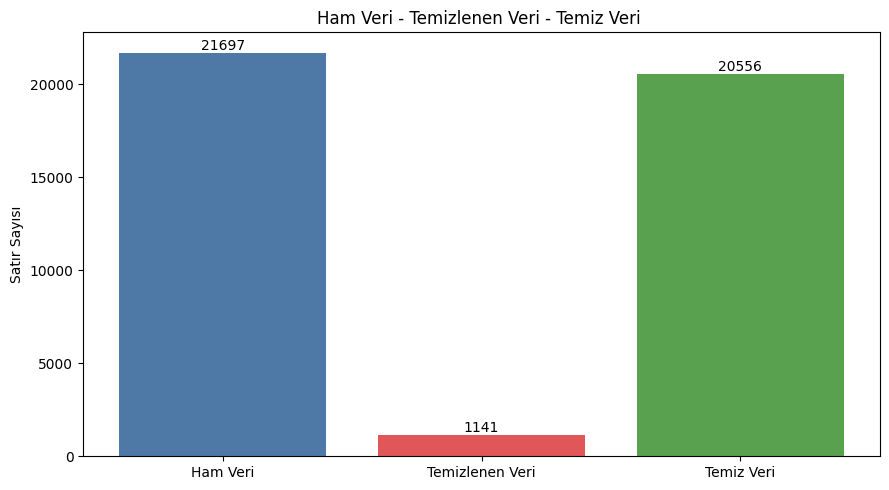

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

# Dosyaları oku
raw = pd.read_csv("turkcell_normalized.csv")          # ham (normalize edilmiş ama filtrelenmemiş)
clean = pd.read_csv("turkcell_clean_filtered.csv")    # filtrelenmiş temiz veri

ham_sayi = len(raw)
temiz_sayi = len(clean)
silinen_sayi = ham_sayi - temiz_sayi   # otomatik hesap

print("Ham:", ham_sayi)
print("Silinen:", silinen_sayi)
print("Temiz:", temiz_sayi)

# 3 bar: Ham, Silinen, Temiz
labels = ["Ham Veri", "Temizlenen Veri", "Temiz Veri"]
values = [ham_sayi, silinen_sayi, temiz_sayi]
colors = ["#4e79a7", "#e15759", "#59a14f"]  # renkli

plt.figure(figsize=(9, 5))
bars = plt.bar(labels, values, color=colors)

plt.title("Ham Veri - Temizlenen Veri - Temiz Veri ")
plt.ylabel("Satır Sayısı")

# Bar üstüne değer yaz
for b in bars:
    h = b.get_height()
    plt.text(b.get_x() + b.get_width()/2, h, f"{int(h)}", ha="center", va="bottom")

plt.tight_layout()
plt.savefig(
    "ham_temiz_veri_karsilastirma.png",
    dpi=300,
    bbox_inches="tight" )
plt.show()


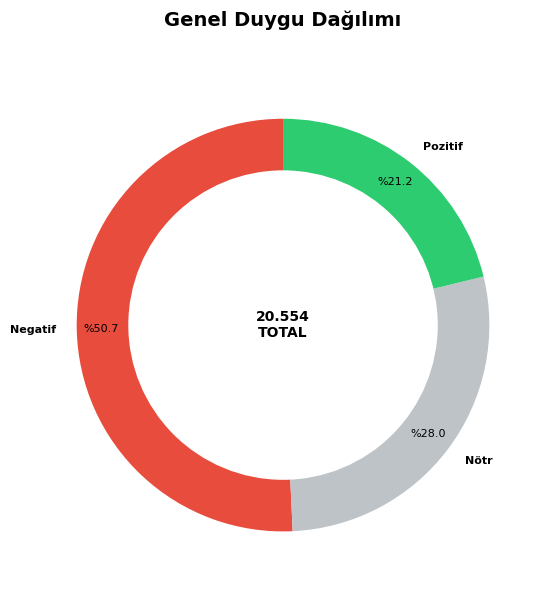

In [53]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import locale
locale.setlocale(locale.LC_ALL, 'tr_TR.UTF-8')


rcParams["font.family"] = "DejaVu Sans"
rcParams["font.size"] = 9
# =========================
# VERİLER
# =========================
labels = ["Negatif", "Nötr", "Pozitif"]
values = [10430, 5762, 4362]
colors = ["#E74C3C", "#BDC3C7", "#2ECC71"]


total = sum(values)

# =========================
# GRAFİK
# =========================
plt.figure(figsize=(6,6))

wedges, texts, autotexts = plt.pie(
    values,
    labels=labels,
    colors=colors,
    startangle=90,
    autopct=lambda p: f"%{p:.1f}",
    pctdistance=0.88,
    textprops={"fontsize": 8 ,"fontweight": "bold"})

# Yüzdeleri normal yap
for t in autotexts:
    t.set_fontweight("normal")

# Etiketleri bold yap
for t in texts:
    t.set_fontweight("bold")

# Ortayı boşalt (halka)
centre_circle = plt.Circle((0,0), 0.75, fc="white")
plt.gca().add_artist(centre_circle)

# Orta yazı
plt.text(
    0, 0,
    f"{locale.format_string('%d', total, grouping=True)}\nTOTAL",
    ha="center",
    va="center",
    fontsize=10,
    fontweight="bold"
)

plt.title("Genel Duygu Dağılımı", pad=30,fontsize=14,
    fontweight="bold")
plt.tight_layout()
plt.savefig("duygu_donut.png", dpi=300, bbox_inches="tight")
plt.show()


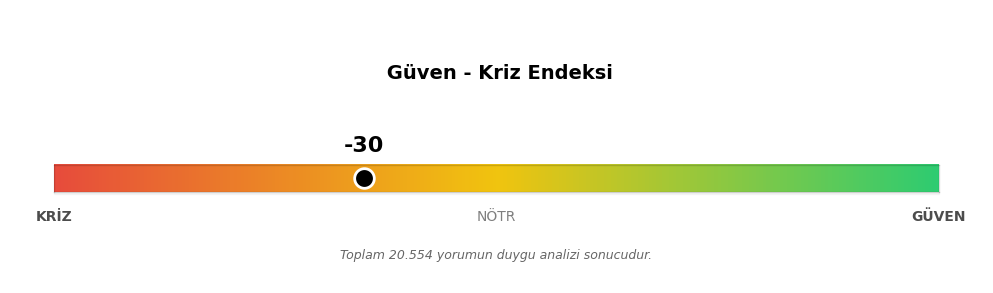

In [62]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# =========================
# VERİ (Girdi değerleri)
# =========================
negatif = 10430
pozitif = 4362
notr = 5762

total = negatif + pozitif + notr
# Skor -100 ile +100 arasında hesaplanır
score = round((pozitif - negatif) / total * 100) 

# =========================
# GÖRSEL AYARLAR (Modern Tasarım)
# =========================
fig, ax = plt.subplots(figsize=(10, 3))
ax.set_xlim(-110, 110)
ax.set_ylim(-1, 2)
ax.axis("off") # Eksenleri gizle

# 1. Renk Gradyanı Oluşturma (Kırmızı -> Sarı -> Yeşil)
gradient = np.linspace(0, 1, 256).reshape(1, -1)
cmap = mcolors.LinearSegmentedColormap.from_list("kriz_guven", ["#E74C3C", "#F1C40F", "#2ECC71"])

# Arka plandaki gradyan çubuk
ax.imshow(gradient, aspect="auto", cmap=cmap, extent=[-100, 100, 0, 0.3], zorder=1)
# Gradyan çubuğa ince çerçeve
ax.plot([-100, 100], [0, 0], color="black", alpha=0.15, linewidth=1, zorder=2)
ax.plot([-100, 100], [0.3, 0.3], color="black", alpha=0.15, linewidth=1, zorder=2)
ax.plot([-100, -100], [0, 0.3], color="black", alpha=0.15, linewidth=1, zorder=2)
ax.plot([100, 100], [0, 0.3], color="black", alpha=0.15, linewidth=1, zorder=2)

# Çok hafif gölge hissi
ax.fill_between([-100, 100], -0.02, 0, color="black", alpha=0.03, zorder=0)


# 2. Gösterge Noktası (Skorun olduğu yer)
# Noktayı tam skorun olduğu yere yerleştiriyoruz
ax.scatter(score, 0.15, s=200, color="black", edgecolor="white", linewidth=2, zorder=3)

# 3. Metinler ve Etiketler
# Noktanın tam üzerindeki küçük skor yazısı
ax.text(score, 0.5, f"{score}", ha="center", va="center", fontsize=16, fontweight="bold", color="black")

# Uçlardaki "Kriz" ve "Güven" yazıları
ax.text(-100, -0.2, "KRİZ", ha="center", va="top", fontsize=10, fontweight="bold", alpha=0.7)
ax.text(100, -0.2, "GÜVEN", ha="center", va="top", fontsize=10, fontweight="bold", alpha=0.7)
ax.text(0, -0.2, "NÖTR", ha="center", va="top", fontsize=10, alpha=0.5)

# Başlık
ax.text(0, 1.3, " Güven - Kriz Endeksi", ha="center", va="center", fontsize=14, fontweight="bold")

# Alt bilgi (Opsiyonel)
ax.text(0, -0.7, f"Toplam {format(total, ',').replace(',', '.')} yorumun duygu analizi sonucudur.", 
        ha="center", va="center", fontsize=9, style="italic", alpha=0.6)

plt.tight_layout()
plt.show()

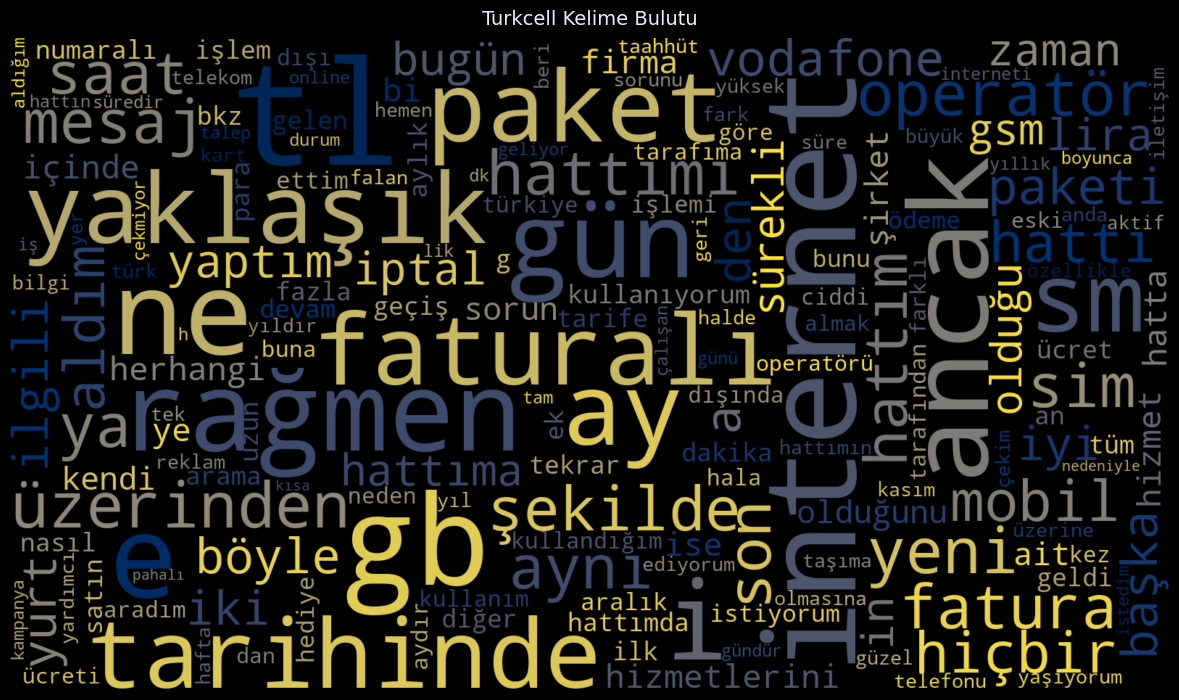

✅ Word cloud kaydedildi: turkcell_wordcloud_black.png


In [115]:
import re
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# =========================
# 1) VERİYİ OKU
# =========================
# Dosya adını gerekirse değiştir
df = pd.read_csv("turkcell_clean_filtered.csv")

# Metin sütununu otomatik bul
possible_cols = ["metin", "text", "entry", "ozet", "yorum", "comment"]
text_col = next((c for c in possible_cols if c in df.columns), None)

if text_col is None:
    raise ValueError(f"Metin sütunu bulunamadı. Kolonlar: {list(df.columns)}")

texts = df[text_col].astype(str).tolist()

# =========================
# 2) METİN TEMİZLEME
# =========================
def clean_text(t):
    t = t.lower()
    t = re.sub(r"http\S+|www\.\S+", " ", t)   # linkler
    t = re.sub(r"\S+@\S+", " ", t)            # e-posta
    t = re.sub(r"\d+", " ", t)                # sayılar
    t = re.sub(r"[^a-zçğıöşü\s]", " ", t)      # özel karakterler (TR harfler kalsın)
    t = re.sub(r"\s+", " ", t).strip()
    return t

cleaned_texts = [clean_text(t) for t in texts]
all_text = " ".join(cleaned_texts)

# =========================
# 3) STOPWORDS (TÜRKÇE + PROJE ÖZEL)
# =========================
tr_stopwords = {
    "ve","veya","ile","de","da","ki","çok","daha","en","bir","bu","şu","o",
    "ben","sen","biz","siz","onlar","bana","sana","bize","size","beni","seni",
    "var","yok","mi","mı","mu","mü","ama","fakat","çünkü","için","gibi",
    "olarak","kadar","sonra","önce","her","hiç","hep","şey","şeyi","şeyler",
    "zaten","yine","ayrıca","hem","sadece","artık","şimdi","az",
    "olan","oldu","oluyor","olması","olacak","olsun","olabilir","değil",
    "evet","hayır","tamam","lütfen","teşekkür","merhaba",
    "benim","senin","bizim","sizin","onun","bunun","şunun","onların",
    "yani","bile","üzere","dedi","diyor","dedim","diye","yüzden",
    # marka ve çok genel kelimeler
    "turkcell","hat","hatt","telefon","numara","müşteri","hizmetleri"
}

# =========================
# 4) WORD CLOUD OLUŞTUR
# =========================
wc = WordCloud(
    width=1600,
    height=900,
    background_color="black",
    stopwords=tr_stopwords,
    max_words=180,
    max_font_size=200,
    min_font_size=12,
    relative_scaling=0.4,
    collocations=False,
    prefer_horizontal=0.85,
    contour_width=0,
    contour_color="#E6F0FA",
    colormap="cividis"
).generate(all_text)


# =========================
# 5) GÖSTER + KAYDET
# =========================
plt.figure(figsize=(12,7), facecolor="black")
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title(
    "Turkcell Kelime Bulutu",
    fontsize=14,
    color="#E6F0FA",
    pad=10
)

plt.tight_layout()
plt.savefig("turkcell_wordcloud_black.png", dpi=300, bbox_inches="tight", facecolor="black")
plt.show()

print("✅ Word cloud kaydedildi: turkcell_wordcloud_black.png")
